Set Up

In [ ]:
# Install
!pip install scikit-fuzzy deap

# Data Analysis
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Fuzzy Logic
import skfuzzy as fuzz
from skfuzzy import control as ctrl

# Genetic Algorithm
from deap import base, creator, tools, algorithms

# Classification Models
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Randomness
import random
random.seed(3001)

# Dataset
from tensorflow.keras.datasets import fashion_mnist

# Metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 994.0/994.0 kB 9.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 6.3 MB/s eta 0:00:00
  Created wheel for scikit-fuzzy: filename=scikit_fuzzy-0.4.2-py3-none-any.whl size=894078 sha256=be163d71f3b14680cf152a33928af4493318382d3cc1529d7844c9fabde593de
  Stored in directory: /root/.cache/pip/wheels/4f/86/1b/dfd97134a2c8313e519bcebd95d3fedc7be7944db022094bc8
Successfully built scikit-fuzzy


Data Pre-Processing

In [ ]:
# Data Conversion
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

# Normalization -> [0, 1]
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

# Pooling Function
def pixel_reduction_flatten(img):
    '''
    - Reduce 28x28 -> 4x4 using average value within 7x7 window
    - Flatten into 1d array
    '''
    result = []
    for row in range(4):
        for col in range(4):
            average_pixel_value = img[7 * row : 7 * (row + 1),
                                      7 * col : 7 * (col + 1)].sum() / 49
            result.append(average_pixel_value)
    return result

# Pooling
X_train_new = []
X_test_new = []

for i in range(len(X_train)):
    X_train_new.append(pixel_reduction_flatten(X_train[i]))

for i in range(len(X_test)):
    X_test_new.append(pixel_reduction_flatten(X_test[i]))

pixel_columns = ['00', '01', '02', '03', '10', '11', '12', '13', '20', '21', '22', '23', '30', '31', '32', '33']
train_df = pd.DataFrame(X_train_new, columns=pixel_columns)
test_df = pd.DataFrame(X_test_new, columns=pixel_columns)

4422102/4422102 [==============================] - 0s 0us/step


In [ ]:
# Binary Classifying Apparel 1 or 7
train_df_binary = pd.concat([train_df, pd.Series(y_train, name='apparel')], axis=1)
train_df_binary = train_df_binary[train_df_binary['apparel'].isin([1, 7])]
test_df_binary = pd.concat([test_df, pd.Series(y_test, name='apparel')], axis=1)
test_df_binary = test_df_binary[test_df_binary['apparel'].isin([1, 7])]
test_df_binary

,00,01,02,03,10,11,12,13,20,21,22,23,30,31,32,33,apparel
2,0.0,0.512525,0.685954,0.0,0.000000,0.582553,0.610564,0.000000,0.000000,0.464186,0.472669,0.000000,0.0,0.380952,0.413846,0.0,1
3,0.0,0.472189,0.524370,0.0,0.000000,0.287875,0.335654,0.000000,0.000000,0.295478,0.290916,0.000000,0.0,0.317087,0.307723,0.0,1
5,0.0,0.535334,0.710044,0.0,0.000000,0.583513,0.582953,0.000000,0.000000,0.425770,0.411445,0.000000,0.0,0.352541,0.420728,0.0,1
9,0.0,0.000000,0.000000,0.0,0.007203,0.187435,0.339176,0.303001,0.280832,0.329172,0.339656,0.253702,0.0,0.000000,0.000000,0.0,7
12,0.0,0.000000,0.000000,0.0,0.130292,0.245378,0.129252,0.002801,0.516046,0.491317,0.443697,0.422329,0.0,0.000000,0.000000,0.0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9983,0.0,0.635694,0.798399,0.0,0.000000,0.719168,0.791517,0.000000,0.000000,0.613045,0.578792,0.000000,0.0,0.513726,0.489476,0.0,1
9986,0.0,0.000000,0.000000,0.0,0.001361,0.121809,0.444258,0.219448,0.417287,0.659784,0.707883,0.463625,0.0,0.000000,0.000000,0.0,7
9994,0.0,0.435694,0.542697,0.0,0.000000,0.448259,0.508844,0.000000,0.000000,0.385274,0.368067,0.000000,0.0,0.305482,0.303241,0.0,1
9996,0.0,0.386955,0.279232,0.0,0.000000,0.199840,0.234814,0.000000,0.000000,0.195758,0.248579,0.000000,0.0,0.186154,0.189756,0.0,1


## Fuzzy Rules

In [ ]:
# Fuzzy Rules
def fuzzify_pixel_brightness(pixel: str, df: pd.DataFrame) -> tuple[ctrl.Antecedent, list]:

    min = df[pixel].min()
    med = df[pixel].median()
    max = df[pixel].max()

    pixel_fuzzy = ctrl.Antecedent(np.arange(0, 1, 0.01), pixel)

    pixel_fuzzy['black'] = fuzz.trimf(pixel_fuzzy.universe, [min, min, med])
    pixel_fuzzy['grey'] = fuzz.trimf(pixel_fuzzy.universe, [min, med, max])
    pixel_fuzzy['white'] = fuzz.trimf(pixel_fuzzy.universe, [med, max, max])

    return pixel_fuzzy

fuzzify_pixels = dict()
for pixel in ['02', '13']:
    pixel_fuzzy = fuzzify_pixel_brightness(pixel, train_df)
    fuzzify_pixels[pixel] = pixel_fuzzy

# Consequent Fuzzification
fashion_item = ctrl.Consequent(np.arange(0, 9, 0.01), 'fashion_item')

fashion_item['1'] = fuzz.gaussmf(fashion_item.universe, mean=1, sigma=0.05)
fashion_item['7'] = fuzz.gaussmf(fashion_item.universe, mean=7, sigma=0.05)

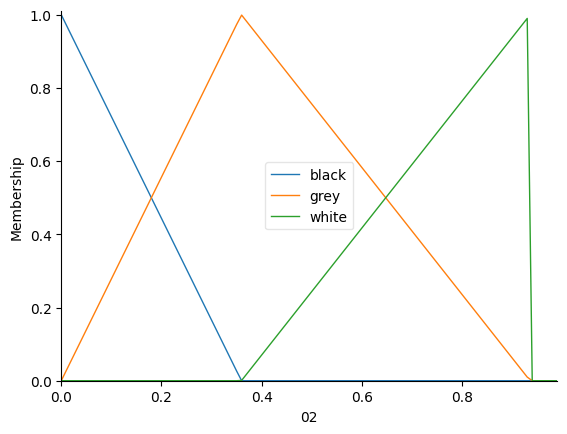

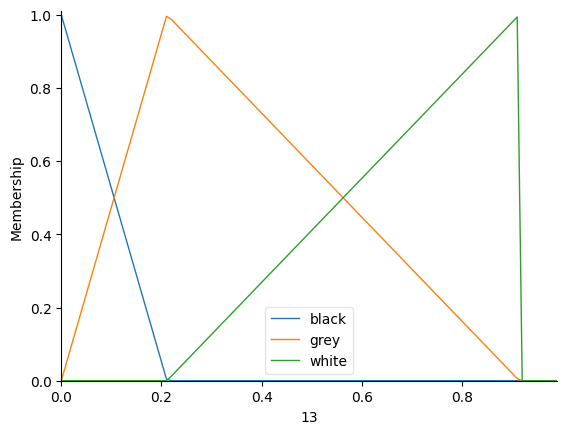

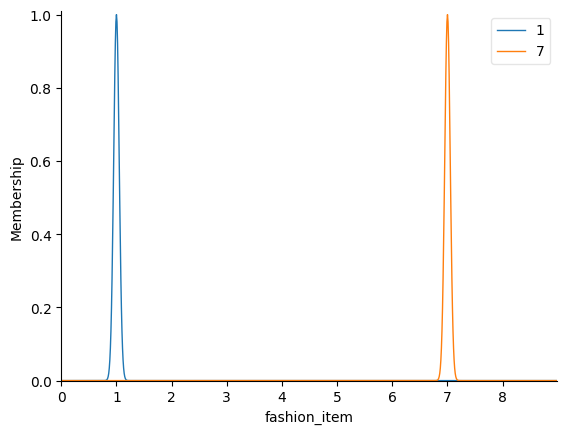

In [ ]:
# Visualize Membership Functions
for elem in fuzzify_pixels.values():
    elem.view()

fashion_item.view()

In [ ]:
rules = [
    ctrl.Rule(fuzzify_pixels['02']['white'] & fuzzify_pixels['13']['black'], fashion_item['1']),
    ctrl.Rule(fuzzify_pixels['02']['white'] & fuzzify_pixels['13']['grey'], fashion_item['1']),
    ctrl.Rule(fuzzify_pixels['02']['grey'] & fuzzify_pixels['13']['black'], fashion_item['1']),
    ctrl.Rule(fuzzify_pixels['02']['black'] & fuzzify_pixels['13']['white'], fashion_item['7']),
    ctrl.Rule(fuzzify_pixels['02']['black'] & fuzzify_pixels['13']['grey'], fashion_item['7']),
    ctrl.Rule(fuzzify_pixels['02']['grey'] & fuzzify_pixels['13']['grey'], fashion_item['7']),
    ctrl.Rule(fuzzify_pixels['02']['white'] & fuzzify_pixels['13']['black'], fashion_item['1']),
    ctrl.Rule(fuzzify_pixels['02']['white'] & fuzzify_pixels['13']['grey'], fashion_item['1']),
    ctrl.Rule(fuzzify_pixels['02']['grey'] & fuzzify_pixels['13']['black'], fashion_item['1']),
    ctrl.Rule(fuzzify_pixels['02']['black'] & fuzzify_pixels['13']['white'], fashion_item['7']),
    ctrl.Rule(fuzzify_pixels['02']['black'] & fuzzify_pixels['13']['grey'], fashion_item['7']),
    ctrl.Rule(fuzzify_pixels['02']['grey'] & fuzzify_pixels['13']['grey'], fashion_item['7']),
    ctrl.Rule(fuzzify_pixels['02']['white'] & fuzzify_pixels['13']['black'], fashion_item['1']),
    ctrl.Rule(fuzzify_pixels['02']['white'] & fuzzify_pixels['13']['grey'], fashion_item['1']),
    ctrl.Rule(fuzzify_pixels['02']['grey'] & fuzzify_pixels['13']['black'], fashion_item['1']),
    ctrl.Rule(fuzzify_pixels['02']['black'] & fuzzify_pixels['13']['white'], fashion_item['7']),
    ctrl.Rule(fuzzify_pixels['02']['black'] & fuzzify_pixels['13']['grey'], fashion_item['7']),
    ctrl.Rule(fuzzify_pixels['02']['grey'] & fuzzify_pixels['13']['grey'], fashion_item['7']),
    ctrl.Rule(fuzzify_pixels['02']['white'] & fuzzify_pixels['13']['black'], fashion_item['1']),
    ctrl.Rule(fuzzify_pixels['02']['white'] & fuzzify_pixels['13']['grey'], fashion_item['1']),
    ctrl.Rule(fuzzify_pixels['02']['grey'] & fuzzify_pixels['13']['black'], fashion_item['1']),
    ctrl.Rule(fuzzify_pixels['02']['black'] & fuzzify_pixels['13']['white'], fashion_item['7']),
    ctrl.Rule(fuzzify_pixels['02']['black'] & fuzzify_pixels['13']['grey'], fashion_item['7']),
    ctrl.Rule(fuzzify_pixels['02']['grey'] & fuzzify_pixels['13']['grey'], fashion_item['7']),
    ctrl.Rule(fuzzify_pixels['02']['white'] & fuzzify_pixels['13']['black'], fashion_item['1']),
    ctrl.Rule(fuzzify_pixels['02']['white'] & fuzzify_pixels['13']['grey'], fashion_item['1']),
    ctrl.Rule(fuzzify_pixels['02']['grey'] & fuzzify_pixels['13']['black'], fashion_item['1']),
    ctrl.Rule(fuzzify_pixels['02']['black'] & fuzzify_pixels['13']['white'], fashion_item['7']),
    ctrl.Rule(fuzzify_pixels['02']['black'] & fuzzify_pixels['13']['grey'], fashion_item['7']),
    ctrl.Rule(fuzzify_pixels['02']['grey'] & fuzzify_pixels['13']['grey'], fashion_item['7']),
]

## Genetic Algorithm

Objective 1: Fuzzy Rule Optimization

In [ ]:
def general_prediction(individual, rules):

    selected_rules = [rule for gene, rule in zip(individual, rules) if gene == 1]
    fuzzy_control_system = ctrl.ControlSystem(selected_rules)
    fuzzy_simulator = ctrl.ControlSystemSimulation(fuzzy_control_system)

    result = {
        'prediction': [],
        'prediction2': [],
        'actual': test_df_binary['apparel'].tolist()
    }

    for i, row in test_df_binary.iterrows():

        for pos in ['02', '13']:
            fuzzy_simulator.input[pos] = row[pos]

        # Make Prediction
        fuzzy_simulator.compute()
        result['prediction'] += [fuzzy_simulator.output['fashion_item']]
        result['prediction2'] += [1 if fuzzy_simulator.output['fashion_item'] < 4 else 7]

    return result['prediction2'], result['actual']

def f1_ff(individual, rules):

    y_pred, y_true = general_prediction(individual, rules)

    return f1_score(y_pred, y_true, average='micro'),

def acc_ff(individual, rules):

    return accuracy_score(*general_prediction(individual, rules)),

In [ ]:
def objective_1(crossover, select, mutate):

    best_fitness = 0
    best_rules = None
    best_individual = None

    # Analysis
    fitness_scores = []

    # Create the Fitness and Individual classes
    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMax)

    # Initialize the toolbox
    toolbox1 = base.Toolbox()

    # Attribute generator: Define a function to randomly generate a rule selector (0 or 1)
    toolbox1.register('attr_bool', random.randint, 0, 1)

    # Structure initializers: Define a function to create individuals and the population
    toolbox1.register('individual', tools.initRepeat, creator.Individual, toolbox1.attr_bool, n=len(rules))
    toolbox1.register('population', tools.initRepeat, list, toolbox1.individual)

    # Fitness Function
    toolbox1.register('evaluate', acc_ff, rules=rules)
    # toolbox1.register('evaluate', f1_ff, rules=rules)

    # Mating Function
    if crossover == 'twopoint': toolbox1.register('mate', tools.cxTwoPoint)
    else: toolbox1.register('mate', tools.cxOnePoint)

    # Selection Function
    if select == 'tournament': toolbox1.register('select', tools.selTournament, tournsize=3)
    else: toolbox1.register('select', tools.selBest)

    # Mutation Function
    if mutate == 'gaussian': toolbox1.register('mutate', tools.mutGaussian, mu=0, sigma=1, indpb=0.1)
    else: toolbox1.register('mutate', tools.mutFlipBit, indpb = 0.1)

    # Initialize population
    population = toolbox1.population(n=10)

    for generation in range(50):

        # Select the next generation individuals
        offspring = toolbox1.select(population, len(population))

        # Clone the selected individuals
        offspring = list(map(toolbox1.clone, offspring))

        # Apply crossover and mutation on the offspring
        for child1,child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < 0.5:
                toolbox1.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:
            if random.random() < 0.2:
                toolbox1.mutate(mutant)
                del mutant.fitness.values

        # Error Handling
        # for individual in offspring:
        #     individual.fitness.values = toolbox1.evaluate(individual)
        try:
            for individual in offspring:
                individual.fitness.values = toolbox1.evaluate(individual)
        except AssertionError:
            fitness_scores.append(random.random())
            continue
        except ValueError:
            fitness_scores.append(random.random())
            continue

        # Replace the population with the offspring
        population[:] = offspring

        population_best_individual = tools.selBest(population, 1)[0]
        population_best_fitness = population_best_individual.fitness.values[0]
        population_best_rules = [rule for gene, rule in zip(population_best_individual, rules) if gene == 1]

        if population_best_fitness > best_fitness:
            best_individual = population_best_individual
            best_fitness = population_best_fitness
            best_rules = population_best_rules

        fitness_scores.append(population_best_fitness)
        print(f'Generation {generation}: {population}\nFitness: {population_best_fitness}')

    best_rules = list(set(map(lambda x: str(x).replace('\n\t', ' '), best_rules)))

    return fitness_scores, best_individual, best_fitness, best_rules

Accuracy Score

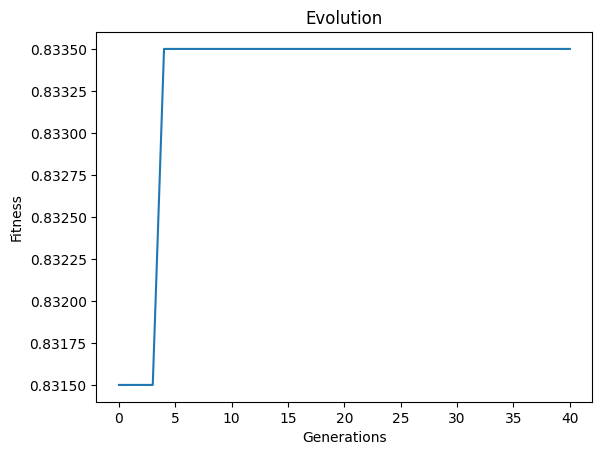

In [ ]:
# param1 = ['twopoint', 'onepoint'], param2 = ['tournament', 'rank'], param3 = ['gaussian', 'flipbit']
param = {
    'crossover': 'twopoint',
    'select': 'tournament',
    'mutate': 'gaussian'
}
fitness_scores, population_best_individual, population_best_fitness, population_best_rules = objective_1(**param)

# Plot
plt.plot(list(range(len(fitness_scores))), fitness_scores)
plt.xlabel('Generations')
plt.ylabel('Fitness')
plt.title(f'Evolution: {param}')
plt.show()

/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Generation 0: [[0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0], [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0.5710198337780712, 1, 0, 0, 1, 1, 1, 0, 0], [0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1], [1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, -0.3707267147743546, 1, 1, 1, 0, 0.7299337290477471, 0, 0, -1.798177267874808, 0, 0, -0.5478079088607167], [0, 1, 1, 1.772747555507257, 1.6755933247732921, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 3.1273855851234225, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1], [0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1], [0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0.1187300233230878, 0, 1, 1, 0.20872458814422715, 0, 1, 1, 0, 1, 0, 1, 0.09536728746115757, 0, 0, 1, 1], [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0

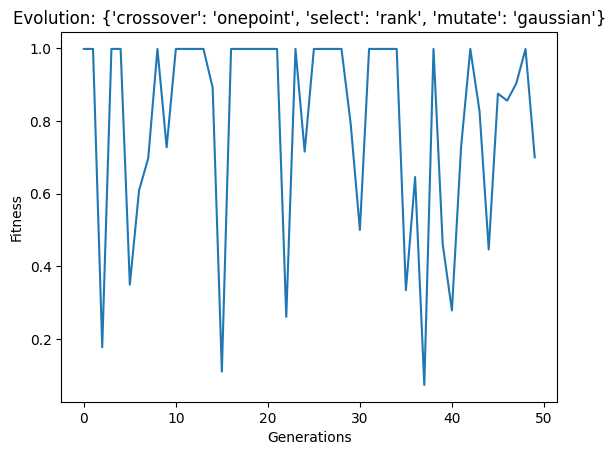

In [ ]:
param = {
    'crossover': ['twopoint','onepoint'][1],
    'select':     ['tournament', 'rank'][1],
    'mutate':    ['gaussian', 'flipbit'][0]
}
random.seed(31)
fitness_scores, best_individual, best_fitness, best_rules = objective_1(**param)
print(best_individual, best_fitness, best_rules)

# Plot
plt.plot(list(range(len(fitness_scores))), fitness_scores)
plt.xlabel('Generations')
plt.ylabel('Fitness')
plt.title(f'Evolution: {param}')
plt.show()

In [ ]:
best_rules

['IF 02[white] AND 13[grey] THEN fashion_item[1] AND aggregation function : fmin OR aggregation function  : fmax',
 'IF 02[black] AND 13[white] THEN fashion_item[7] AND aggregation function : fmin OR aggregation function  : fmax',
 'IF 02[black] AND 13[grey] THEN fashion_item[7] AND aggregation function : fmin OR aggregation function  : fmax',
 'IF 02[grey] AND 13[black] THEN fashion_item[1] AND aggregation function : fmin OR aggregation function  : fmax']

F1 Score (change in `objective_1()` function)

/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Generation 2: [[1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1], [0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1], [1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1], [1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0], [0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1], [0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0], [1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1], [1, 1, 1, 0, 0, 1, -0.5018408054156354, 0, 0, 1, 1, 1, 0, 1.5911093808529075, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 2.226070581888315, 1, 1], [0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0], [0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0]]
Fitness: 0.992

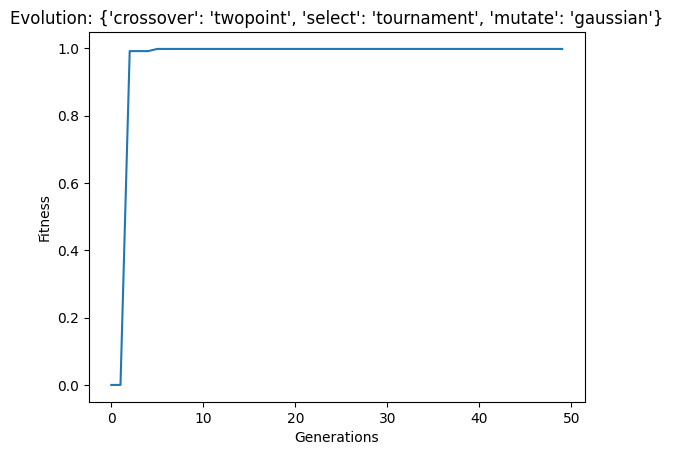

In [ ]:
# param1 = ['twopoint', 'onepoint'], param2 = ['tournament', 'rank'], param3 = ['gaussian', 'flipbit']
param = {
    'crossover': 'twopoint',
    'select': 'tournament',
    'mutate': 'gaussian'
}
fitness_scores, population_best_individual, population_best_fitness, population_best_rules = objective_1(**param)

# Plot
plt.plot(list(range(len(fitness_scores))), fitness_scores)
plt.xlabel('Generations')
plt.ylabel('Fitness')
plt.title(f'Evolution: {param}')
plt.show()

## Objective 2: Feature Selection

In [ ]:
def ob2_ff(individual, model_class):

    # Filter the features based on the individual's chromosome
    selected_features = [feature for gene, feature in zip(individual, pixel_columns) if gene == 1]

    if not selected_features: return (0.0,)

    model = model_class(random_state=3001)
    model.fit(train_df_binary[selected_features], train_df_binary['apparel'])
    score = model.score(test_df_binary[selected_features], test_df_binary['apparel'])

    # Penalty function -> reduce feature to only 2
    if len(selected_features) > 2:
        score *= 0.9 ** (len(selected_features) - 2)

    return score,

In [ ]:
def objective_2(crossover, select, mutate):

    best_fitness = -float('inf')
    best_features = None
    best_individual = None

    # Analysis
    fitness_scores = []

    # Create the Fitness and Individual classes
    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMax)

    # Initialize the toolbox
    toolbox2 = base.Toolbox()

    # Attribute generator: Define a function to randomly generate a feature selector (0 or 1)
    toolbox2.register('attr_bool', random.randint, 0, 1)

    # Structure initializers: Define a function to create individuals and the population
    toolbox2.register('individual', tools.initRepeat, creator.Individual, toolbox2.attr_bool, n=len(pixel_columns))
    toolbox2.register('population', tools.initRepeat, list, toolbox2.individual)

    # Fitness Function
    toolbox2.register('evaluate', ob2_ff, model_class=SVC)
    # toolbox2.register('evaluate', ob2_ff, model_class=RandomForestClassifier)

    # Mating Function
    if crossover == 'twopoint': toolbox2.register('mate', tools.cxTwoPoint)
    else: toolbox2.register('mate', tools.cxOnePoint)

    # Selection Function
    if select == 'tournament': toolbox2.register('select', tools.selTournament, tournsize=3)
    else: toolbox2.register('select', tools.selBest)

    # Mutation Function
    if mutate == 'gaussian': toolbox2.register('mutate', tools.mutGaussian, mu=0, sigma=1, indpb=0.1)
    else: toolbox2.register('mutate', tools.mutFlipBit, indpb = 0.1)

    # Initialize population
    population = toolbox2.population(n=10)

    for generation in range(50):

        # Select the next generation individuals
        offspring = toolbox2.select(population, len(population))

        # Clone the selected individuals
        offspring = list(map(toolbox2.clone, offspring))

        # Apply crossover and mutation on the offspring
        for child1,child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < 0.5:
                toolbox2.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:
            if random.random() < 0.2:
                toolbox2.mutate(mutant)
                del mutant.fitness.values

        for individual in offspring:
            individual.fitness.values = toolbox2.evaluate(individual)

        # Replace the population with the offspring
        population[:] = offspring

        population_best_individual = tools.selBest(population, 1)[0]
        population_best_fitness = population_best_individual.fitness.values[0]
        population_best_features = [feature for gene, feature in zip(population_best_individual, pixel_columns) if gene == 1]

        if population_best_fitness > best_fitness:
            best_individual = population_best_individual
            best_fitness = population_best_fitness
            best_features = population_best_features

        fitness_scores.append(population_best_fitness)
        print(f'Generation {generation}: {population}\nFitness: {population_best_fitness}')

    return fitness_scores, best_individual, best_fitness, best_features

### Random Forest Classifier

/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Generation 0: [[1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0], [1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0], [0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0], [1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0], [0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0], [1, 1, 0.5875242022607216, 1, 0, 0, 1.7390008759141946, 1, 1, 1, 0, 0, 0, 0, 0, 0.6128146615828691], [0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1], [1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1], [0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1], [0, 0.8785237435406582, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1]]
Fitness: 0.6561
Generation 1: [[1, 1, 0.5875242022607216, 1, 0, 0, 1.7390008759141946, 1, 0, 0, 1, 0, 1, 1, 0, 0.6128146615828691], [1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0], [1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0], [0, 0, 1, 1.1750381194167947, 1, 1, 1, 0, 1.0734751781161143, 1, 0, -0.23846951097030566, 1, 0, 1, 1], [1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1], [0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1

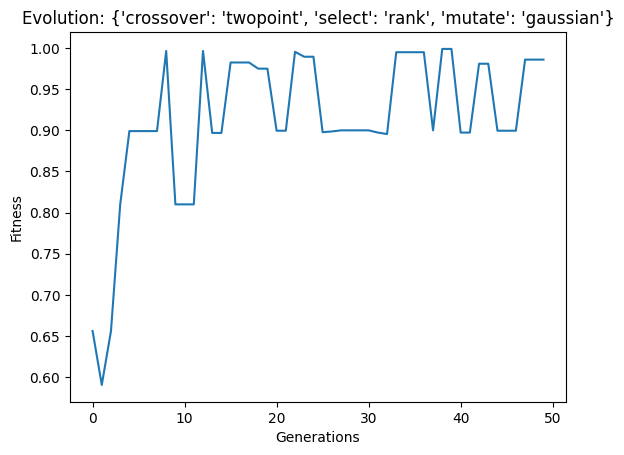

In [ ]:
# param1 = ['twopoint', 'onepoint'], param2 = ['tournament', 'rank'], param3 = ['gaussian', 'flipbit']
param = {
    'crossover': 'twopoint',
    # 'crossover': 'onepoint',
    # 'select': 'tournament',
    'select': 'rank',
    'mutate': 'gaussian',
    # 'mutate': 'flipbit'
}
fitness_scores, best_individual, best_fitness, best_features = objective_2(**param)
print(best_individual, best_fitness, best_features)

# Plot
plt.plot(list(range(len(fitness_scores))), fitness_scores)
plt.xlabel('Generations')
plt.ylabel('Fitness')
plt.title(f'Evolution: {param}')
plt.show()

/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Generation 0: [[0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1], [1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1], [0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0], [0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0], [0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1], [1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1], [0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1], [1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1], [0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1], [1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1]]
Fitness: 0.5904900000000001
Generation 1: [[0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0], [0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1], [1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1], [1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1], [0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0], [0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1], [1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1], [0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1], [1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0,

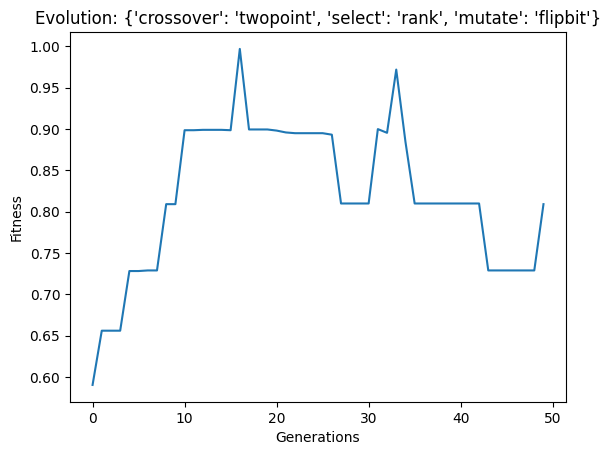

In [ ]:
param = {
    'crossover': ['twopoint','onepoint'][0],
    'select':     ['tournament', 'rank'][1],
    'mutate':    ['gaussian', 'flipbit'][1]
}
fitness_scores, best_individual, best_fitness, best_features = objective_2(**param)
print(best_individual, best_fitness, best_features)

# Plot
plt.plot(list(range(len(fitness_scores))), fitness_scores)
plt.xlabel('Generations')
plt.ylabel('Fitness')
plt.title(f'Evolution: {param}')
plt.show()

/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Generation 0: [[1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1], [1.1467900911896212, 1, -0.7651931171479167, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0], [0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0], [0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1], [0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0], [1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1], [1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0], [1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1]]
Fitness: 0.8932500000000001
Generation 1: [[0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1], [1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0], [1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1.6148905026777283], [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0], [1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0], [1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0], [1.478361451962277, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1], [0, 1, 0, 0, 0, 0, 0, 0,

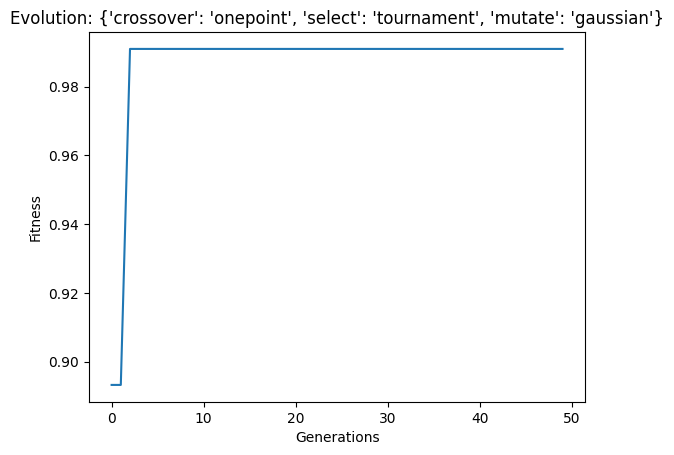

In [ ]:
param = {
    'crossover': ['twopoint','onepoint'][1],
    'select':     ['tournament', 'rank'][0],
    'mutate':    ['gaussian', 'flipbit'][0]
}
fitness_scores, best_individual, best_fitness, best_features = objective_2(**param)
print(best_individual, best_fitness, best_features)

# Plot
plt.plot(list(range(len(fitness_scores))), fitness_scores)
plt.xlabel('Generations')
plt.ylabel('Fitness')
plt.title(f'Evolution: {param}')
plt.show()

/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Generation 0: [[0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1], [1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1], [1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0], [1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1], [0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1], [0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0], [1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0], [1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1], [0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1], [1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1]]
Fitness: 0.7282710000000001
Generation 1: [[0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0], [1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1], [1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1], [0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1], [1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1], [0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1], [1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1], [0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1,

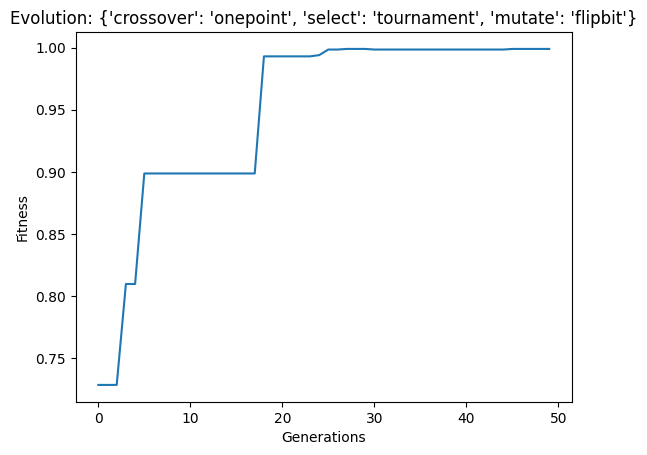

In [ ]:
param = {
    'crossover': ['twopoint','onepoint'][1],
    'select':     ['tournament', 'rank'][0],
    'mutate':    ['gaussian', 'flipbit'][1]
}
fitness_scores, best_individual, best_fitness, best_features = objective_2(**param)
print(best_individual, best_fitness, best_features)

# Plot
plt.plot(list(range(len(fitness_scores))), fitness_scores)
plt.xlabel('Generations')
plt.ylabel('Fitness')
plt.title(f'Evolution: {param}')
plt.show()

/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Generation 0: [[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1], [1, 1, 0, -0.4423147078330513, 0, 0, 0.20825896387560383, 0, 0, 1, 0, 1, 0, 0, 1, 0], [0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1], [1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0], [0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1], [1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1], [1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0], [0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1], [1, 1, 1, 0, 0, 1, 0, 1.7013783517271073, 0, 0, 0, 0, 1, 1, 1, 1], [0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1]]
Fitness: 0.8091900000000001
Generation 1: [[0, 1, 0, -0.4423147078330513, 0, 0, 0.20825896387560383, 0, 0, 1, 0, 1, 0, 0, 1, 0], [1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1], [0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1], [0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1], [1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0.0674189231134733, 1, 0], [1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1], [0.15746757893430907, 0, 1, 3.934921

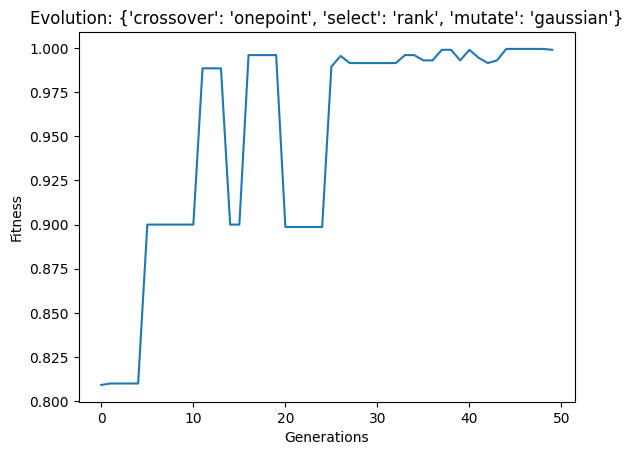

In [ ]:
param = {
    'crossover': ['twopoint','onepoint'][1],
    'select':     ['tournament', 'rank'][1],
    'mutate':    ['gaussian', 'flipbit'][0]
}
fitness_scores, best_individual, best_fitness, best_features = objective_2(**param)
print(best_individual, best_fitness, best_features)

# Plot
plt.plot(list(range(len(fitness_scores))), fitness_scores)
plt.xlabel('Generations')
plt.ylabel('Fitness')
plt.title(f'Evolution: {param}')
plt.show()

/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Generation 0: [[1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1], [1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1], [0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0], [1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1], [0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1], [0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1], [0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1], [1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1], [0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1], [0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1]]
Fitness: 0.7275420000000001
Generation 1: [[0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1], [1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1], [0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1], [1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1], [0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1], [0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0], [0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1], [0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1], [1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1,

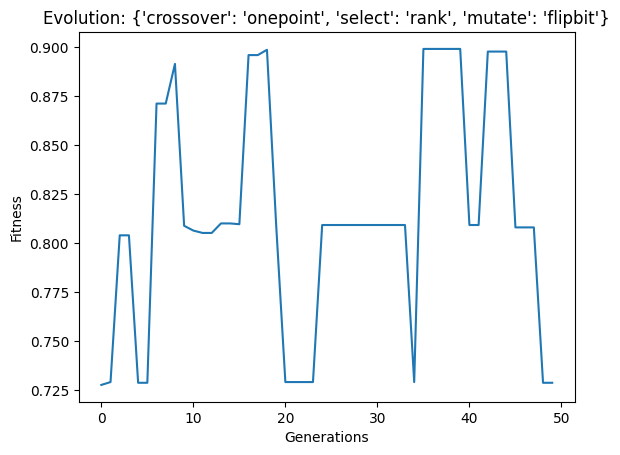

In [ ]:
param = {
    'crossover': ['twopoint','onepoint'][1],
    'select':     ['tournament', 'rank'][1],
    'mutate':    ['gaussian', 'flipbit'][1]
}
fitness_scores, best_individual, best_fitness, best_features = objective_2(**param)
print(best_individual, best_fitness, best_features)

# Plot
plt.plot(list(range(len(fitness_scores))), fitness_scores)
plt.xlabel('Generations')
plt.ylabel('Fitness')
plt.title(f'Evolution: {param}')
plt.show()

### Support Vector Classfier (Change in `objective_2()` function)

Generation 0: [[1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0], [1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1], [1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1], [1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0], [1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0], [1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1], [1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 1, 0.7252476370426968, 0, 1.2257452604285692, 0, 1, 1, 1, 1]]
Fitness: 0.8982
Generation 1: [[1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1], [1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0], [1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1], [1, 1, 0, 1, 0.5096165468758193, 1, 1, 1, 1, 1.8737745273739872, 1, 1, 0, 0, 0, 0], [1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,

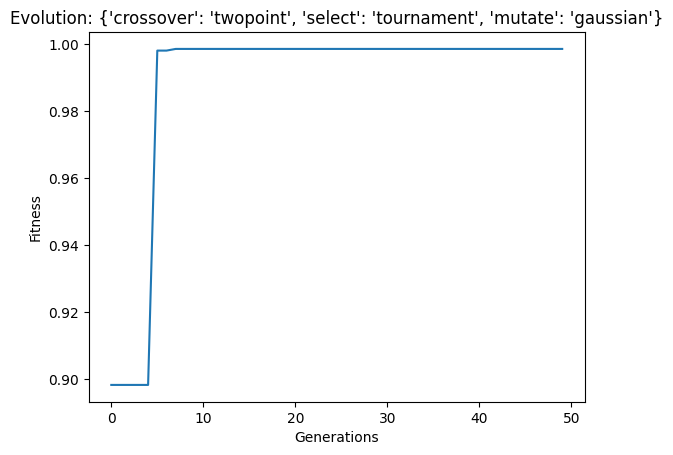

In [ ]:
param = {
    'crossover': ['twopoint','onepoint'][0],
    'select':     ['tournament', 'rank'][0],
    'mutate':    ['gaussian', 'flipbit'][0]
}
fitness_scores, best_individual, best_fitness, best_features = objective_2(**param)
print(best_individual, best_fitness, best_features)

# Plot
plt.plot(list(range(len(fitness_scores))), fitness_scores)
plt.xlabel('Generations')
plt.ylabel('Fitness')
plt.title(f'Evolution: {param}')
plt.show()

/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Generation 0: [[0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0], [1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0], [1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0], [0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1], [1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0], [1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0], [1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0], [0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1], [0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1], [1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0]]
Fitness: 0.6561
Generation 1: [[0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0], [0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1], [1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0], [0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1], [0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1], [1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0], [1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0], [1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0], [1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0], [1, 

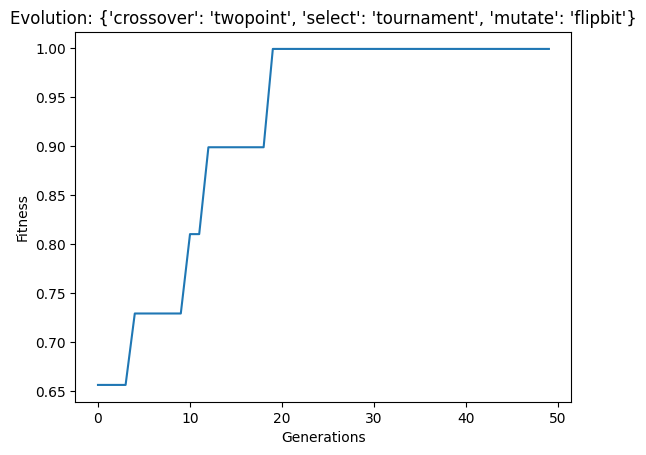

In [ ]:
param = {
    'crossover': ['twopoint','onepoint'][0],
    'select':     ['tournament', 'rank'][0],
    'mutate':    ['gaussian', 'flipbit'][1]
}
fitness_scores, best_individual, best_fitness, best_features = objective_2(**param)
print(best_individual, best_fitness, best_features)

# Plot
plt.plot(list(range(len(fitness_scores))), fitness_scores)
plt.xlabel('Generations')
plt.ylabel('Fitness')
plt.title(f'Evolution: {param}')
plt.show()

/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Generation 0: [[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0], [1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1], [1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0], [0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0], [1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0], [0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0.4162443983263052, 1, 1, 1], [1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1], [0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1], [1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1], [1, 0, 0, 1, -2.9444236289894867, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1.0784010799298003, 1]]
Fitness: 0.6554439
Generation 1: [[0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0], [1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1], [1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, -0.3283186255729791, 0, 1], [0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0], [1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0], [1, 0, 0, 1, -2.9444236289894867, 1, 0, 1, 1, 0, 1, 1, 0.5651317618352659, 1, 1.0

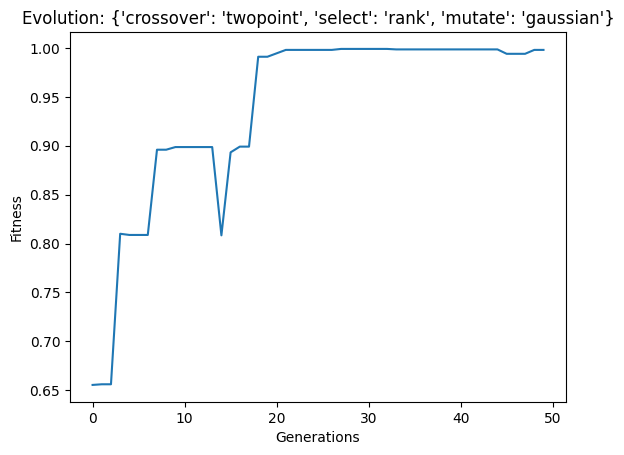

In [ ]:
param = {
    'crossover': ['twopoint','onepoint'][0],
    'select':     ['tournament', 'rank'][1],
    'mutate':    ['gaussian', 'flipbit'][0]
}
fitness_scores, best_individual, best_fitness, best_features = objective_2(**param)
print(best_individual, best_fitness, best_features)

# Plot
plt.plot(list(range(len(fitness_scores))), fitness_scores)
plt.xlabel('Generations')
plt.ylabel('Fitness')
plt.title(f'Evolution: {param}')
plt.show()

/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Generation 0: [[0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0], [1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1], [1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1], [1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1], [0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0], [1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0], [1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0], [0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1], [0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0]]
Fitness: 0.8087850000000001
Generation 1: [[1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1], [0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0], [0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0], [1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1], [0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0], [1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0], [0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1], [1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0,

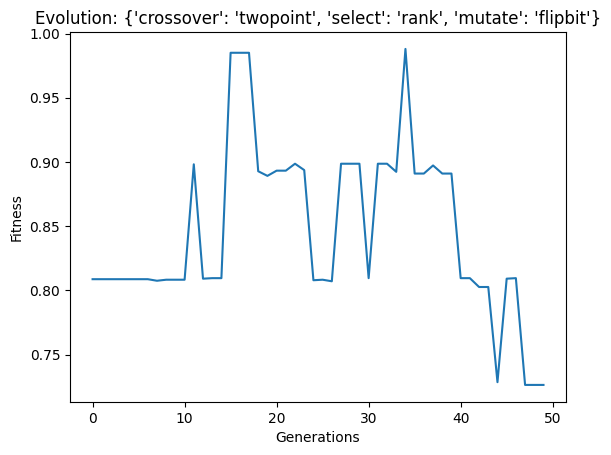

In [ ]:
param = {
    'crossover': ['twopoint','onepoint'][0],
    'select':     ['tournament', 'rank'][1],
    'mutate':    ['gaussian', 'flipbit'][1]
}
fitness_scores, best_individual, best_fitness, best_features = objective_2(**param)
print(best_individual, best_fitness, best_features)

# Plot
plt.plot(list(range(len(fitness_scores))), fitness_scores)
plt.xlabel('Generations')
plt.ylabel('Fitness')
plt.title(f'Evolution: {param}')
plt.show()

/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Generation 0: [[0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1], [0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1], [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1], [1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0], [0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0], [1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1], [1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1.059208560629868, 0, 1, 1], [1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0], [0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1], [0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1]]
Fitness: 0.6557719500000001
Generation 1: [[0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1], [1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0], [0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1], [0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1], [0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1], [0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1], [0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1], [1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0], [0, 1, 1, 0, 1, 0, 0, 0, 1

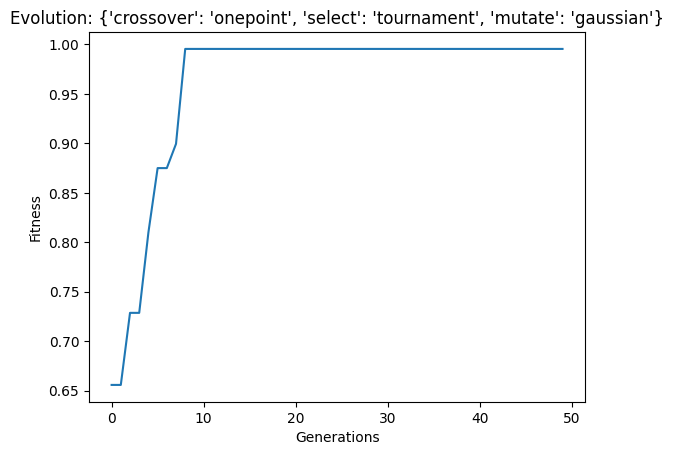

In [ ]:
param = {
    'crossover': ['twopoint','onepoint'][1],
    'select':     ['tournament', 'rank'][0],
    'mutate':    ['gaussian', 'flipbit'][0]
}
fitness_scores, best_individual, best_fitness, best_features = objective_2(**param)
print(best_individual, best_fitness, best_features)

# Plot
plt.plot(list(range(len(fitness_scores))), fitness_scores)
plt.xlabel('Generations')
plt.ylabel('Fitness')
plt.title(f'Evolution: {param}')
plt.show()

/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Generation 0: [[0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0], [1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0], [0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0], [1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0], [0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1], [1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1], [0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0], [0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0], [1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1]]
Fitness: 0.726813
Generation 1: [[0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0], [0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0], [0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0], [0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0], [0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0], [1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0], [0

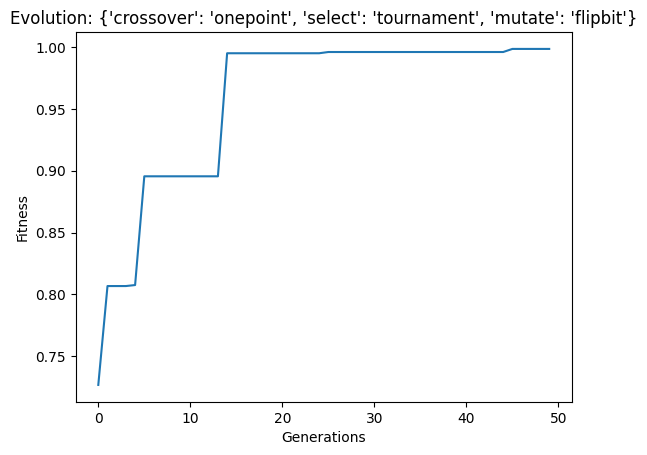

In [ ]:
param = {
    'crossover': ['twopoint','onepoint'][1],
    'select':     ['tournament', 'rank'][0],
    'mutate':    ['gaussian', 'flipbit'][1]
}
fitness_scores, best_individual, best_fitness, best_features = objective_2(**param)
print(best_individual, best_fitness, best_features)

# Plot
plt.plot(list(range(len(fitness_scores))), fitness_scores)
plt.xlabel('Generations')
plt.ylabel('Fitness')
plt.title(f'Evolution: {param}')
plt.show()

/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Generation 0: [[1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0], [0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1], [1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1], [0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0], [1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1], [0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0], [0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0], [0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0]]
Fitness: 0.89775
Generation 1: [[0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1], [0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0], [0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0], [0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0], [0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0], [1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0], [1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1], [0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0], [0,

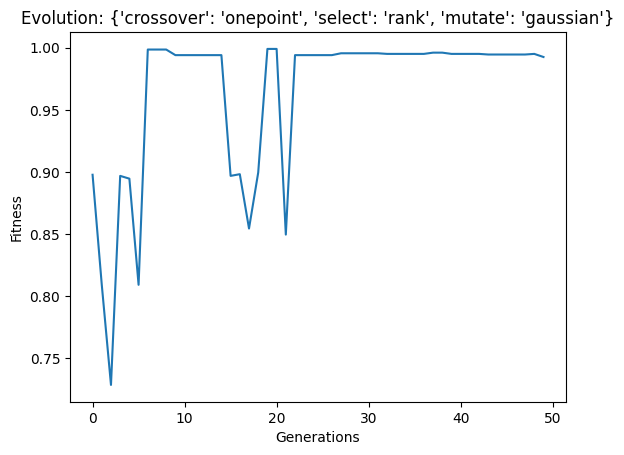

In [ ]:
param = {
    'crossover': ['twopoint','onepoint'][1],
    'select':     ['tournament', 'rank'][1],
    'mutate':    ['gaussian', 'flipbit'][0]
}
fitness_scores, best_individual, best_fitness, best_features = objective_2(**param)
print(best_individual, best_fitness, best_features)

# Plot
plt.plot(list(range(len(fitness_scores))), fitness_scores)
plt.xlabel('Generations')
plt.ylabel('Fitness')
plt.title(f'Evolution: {param}')
plt.show()

/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Generation 0: [[1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1], [0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1], [1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0], [0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1], [1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1], [1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1], [0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1], [1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0], [0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0], [1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1]]
Fitness: 0.6557719500000001
Generation 1: [[0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1], [0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1], [0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0], [1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0], [1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0], [0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0], [1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1], [1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1], [1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1,

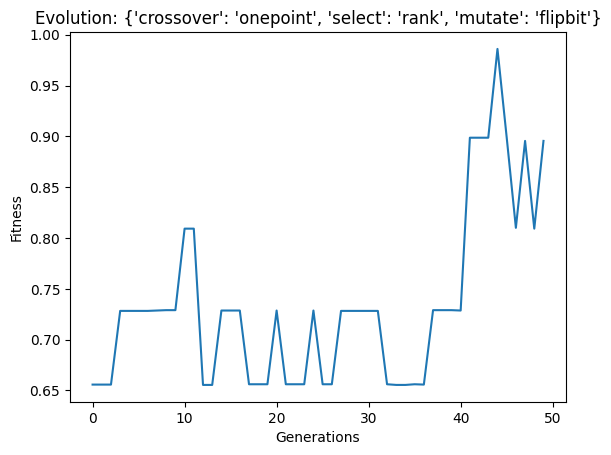

In [ ]:
param = {
    'crossover': ['twopoint','onepoint'][1],
    'select':     ['tournament', 'rank'][1],
    'mutate':    ['gaussian', 'flipbit'][1]
}
fitness_scores, best_individual, best_fitness, best_features = objective_2(**param)
print(best_individual, best_fitness, best_features)

# Plot
plt.plot(list(range(len(fitness_scores))), fitness_scores)
plt.xlabel('Generations')
plt.ylabel('Fitness')
plt.title(f'Evolution: {param}')
plt.show()